### Libraries

In [4]:
import torch
from pykeops.torch import LazyTensor
import numpy as np
from torchvision.transforms import Resize as tv_resize
from PIL import Image
import time
from IPython.display import display
from torch import nn
import math
import skimage.io as io
import os
import skimage.metrics as sm
from skimage.metrics import structural_similarity as ssim
import lpips
import torchvision
from OT_SUOT import OT,SUOT
import cv2
from torchvision.utils import save_image
from os.path import join

from utils import interpolate_shift_map, get_pyramid
from patchmatch import patch_match
from reconstruct import reconstruct
from initialisation import initialisation, initialisation_from_img

from config import (USE_TEXTURE, BETA, MAX_ITER, RESIDUAL_THRESH)

In [3]:
import sys
  
# Prints the list of directories that the 
# interpreter will search for the required module. 
print(sys.path)

sys.path.insert(0, "/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM")

['/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM/PsinSUOT', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python37.zip', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/lib-dynload', '', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages/IPython/extensions', '/home/prof/smignon/.ipython', '/home/prof/smignon/.cache/keops2.1.2/Linux_gpu2.mapmo.univ-orleans.fr_6.6.4-arch1-1_p3.7.13']


### Functions

In [5]:
def save_img(tensor_img, name):
	'''
	save img (tensor form) with the name
	'''
	img = np.clip(tensor_img.squeeze().detach().cpu().numpy(),0,1)
	io.imsave(str(name)+'.png', img)
	return     

def imread(img_name):
    '''
    loads an image as torch.tensor on the selected device
    '''
    np_img = io.imread(img_name)
    tens_img = torch.tensor(np_img, dtype=torch.float, device=DEVICE)
    if torch.max(tens_img) > 1:
        tens_img/=255 													
    if len(tens_img.shape) < 3:
        tens_img = tens_img.unsqueeze(2)						
    if tens_img.shape[2] > 3:										
        tens_img = tens_img[:,:,:3]
    tens_img = tens_img.permute(2,0,1)	
    return tens_img.unsqueeze(0)	

def show(im_deb,col=False):
    im_deb=im_deb.clone().detach()
    im_deb[im_deb>1]=1
    im_deb[im_deb<0]=0
    if col==True:
        im_deb=(255*im_deb.permute(1, 2, 0)).type(dtype=torch.uint8)
    else:
        im_deb=(255*im_deb).type(dtype=torch.uint8)
    imgpil = Image.fromarray(im_deb.numpy()) 
    display(imgpil)
    
class patch_extractor(nn.Module):
    '''
    Module for creating custom patch extractor
    '''
    def __init__(self, patch_size, pad=False,center=False):
        super(patch_extractor, self).__init__()
        self.im2pat = nn.Unfold(kernel_size=patch_size)
        self.pad = pad
        self.padsize = patch_size-1
        self.center=center
        self.patch_size=patch_size

    def forward(self, input, batch_size=0):
        if self.pad:
            input = torch.cat((input, input[:,:,:self.padsize,:]), 2)
            input = torch.cat((input, input[:,:,:,:self.padsize]), 3)
        patches = self.im2pat(input).squeeze(0).transpose(1,0)
        if batch_size > 0:
            idx = torch.randperm(patches.size(0))[:batch_size]
            patches = patches[idx,:]
        if self.center:
            patches = patches - torch.mean(patches,-1).unsqueeze(-1)
        return patches

def gradient_flow(init_img,hr_img,function_OT,n_iter,verbose=False,patch_size=6):
    
    # patchs exctractors
    target_im2pat = patch_extractor(patch_size, pad=False,center=False)
    input_im2pat = patch_extractor(patch_size, pad=False,center=False)
    
    # load y patches
    y= hr_img.clone()
    nuY = target_im2pat(y, -1).contiguous()
    
    # load x
    x=init_img.clone()
    _,_,N,M=x.shape
    x.requires_grad = True
    
    # init g
    g_i=None
    
    # optimizer 
    optimizer = torch.optim.Adam([x], lr=0.01)
    
    # Temps de calcul 
    torch.cuda.synchronize()
    t = time.time()
    for i in range(n_iter):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Exctract x patches 
        nuX = input_im2pat(x, -1).contiguous()
        
        # Compute loss
        if i==0:
            OT_cost,g_i = function_OT(nuX,nuY,g_i,10000)
        if i!=0:
            OT_cost,g_i = function_OT(nuX,nuY,g_i,10)
        
        if verbose==True:
            print('n=',i,', OT: ',OT_cost.clone().item())
        
        # Compute the gradient
        OT_cost.backward()
        
        # Update x
        optimizer.step()
    torch.cuda.synchronize()
    temps=int(time.time()-t)
    print('DONE - total time is '+str(temps)+'s')
    
    return x,temps

###### Psin ######

def get_texture(img):
    """Compute the texture features (gradients).
    Only the magnitude of the gradient in each direction is kept (|gx|, |gy|).
    returns: (H, W, 2)
    """
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gy, gx = np.gradient(grayscale)

    gx = np.abs(gx)
    gy = np.abs(gy)

    return np.stack((gy, gx), axis=-1)

def scale(src, init=None, nb_levels=2, output="."):
    print("Computing features and pyramid...", end=" ", flush=True)
    if USE_TEXTURE:
        texture = get_texture(src)
        src = np.concatenate((src, BETA * texture), axis=-1)
    src_pyramid = get_pyramid(src, nb_levels=nb_levels)
    print("Done")

    patch_match_params = {
        "n_iters": 10,
        "alpha": 0.5,
        "w": max(src.shape[:2]),
    }

    print("Initialisation...", end=" ", flush=True)
    if init is not None:
        img, shift_map = initialisation_from_img(src_pyramid[-1], init, patch_match_params)
    else:
        img, shift_map = initialisation(src_pyramid[-1], patch_match_params)
    print("Done")

    for level in reversed(range(nb_levels)):
        print(f"Level {level}...", end=" ", flush=True)
        src = src_pyramid[level]

        # Interpolate the shift volume and reconstruct at this level
        if level != (nb_levels - 1):
            shift_map = interpolate_shift_map(shift_map, src.shape)
            img = reconstruct(src, shift_map, method="weighted")

        print("Done")
        cv2.imwrite(join(output, f"iter_{level}.png"), img[..., :3] * 255)
        
def generate(src, init=None, nb_levels=3, output="."):
    print("Computing features and pyramid...", end=" ", flush=True)
    if USE_TEXTURE:
        texture = get_texture(src)
        src = np.concatenate((src, BETA * texture), axis=-1)
    src_pyramid = get_pyramid(src, nb_levels=nb_levels)
    print("Done")

    patch_match_params = {
        "n_iters": 10,
        "alpha": 0.5,
        "w": max(src.shape[:2]),
    }

    print("Initialisation...", end=" ", flush=True)
    if init is not None:
        img, shift_map = initialisation_from_img(src_pyramid[-1], init, patch_match_params)
    else:
        img, shift_map = initialisation(src_pyramid[-1], patch_match_params)
    print("Done")

    for level in reversed(range(nb_levels)):
        print(f"Level {level}...", end=" ", flush=True)
        src = src_pyramid[level]

        # Interpolate the shift volume and reconstruct at this level
        if level != (nb_levels - 1):
            shift_map = interpolate_shift_map(shift_map, src.shape)
            img = reconstruct(src, shift_map, method="weighted")

        iteration_nb = 1
        residual = float("inf")
        while iteration_nb <= MAX_ITER and residual > RESIDUAL_THRESH:
            previous_img = img.copy()

            shift_map = patch_match(img, src, shift_map, patch_match_params)
            img = reconstruct(src, shift_map, method="weighted")

            iteration_nb += 1
            residual = np.mean(np.abs(img - previous_img))

        print("Done")
        cv2.imwrite(join(output, f"iter_{level}.png"), img[..., :3] * 255)
        
### Diversity score from a list L of generated images ###

def DIVERSITY(L,ref_img):
    # Liste synthèse images 
    I=torch.stack([0.299*im[0,:,:]+0.587*im[1,:,:]+0.114*im[2,:,:] for im in L])
    I_mu=torch.mean(I,0)
    std_ij=torch.sqrt(torch.mean((I-I_mu)**2,0))
    std_bar=torch.mean(std_ij)
    #print(std_bar)
    
    # Image de référence 
    I_ref=0.299*ref_img[0,:,:]+0.587*ref_img[1,:,:]+0.114*ref_img[2,:,:]
    #I_ref=ref_img
    I_mu_ref=torch.mean(I_ref)
    std_ref=torch.sqrt(torch.mean((I_ref-I_mu_ref)**2))
    #print(std_ref)
    return std_bar/std_ref

### Table 5, Figure 9 (Diversity scores only)

cuda
i= 0 , k= 0
DONE - total time is 59s


Computing features and pyramid... Done
Initialisation... Done
Level 1... Done
Level 0... Done


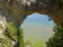

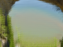

DONE - total time is 204s


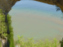

Computing features and pyramid... Done
Initialisation... Done
Level 2... Done
Level 1... Done
Level 0... Done
i= 1 , k= 0
DONE - total time is 57s


Computing features and pyramid... Done
Initialisation... Done
Level 1... Done
Level 0... Done


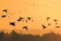

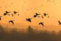

DONE - total time is 176s


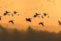

Computing features and pyramid... Done
Initialisation... Done
Level 2... Done
Level 1... Done
Level 0... Done
i= 2 , k= 0
DONE - total time is 58s


Computing features and pyramid... Done
Initialisation... Done
Level 1... Done
Level 0... Done


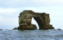

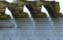

DONE - total time is 177s


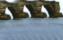

Computing features and pyramid... Done
Initialisation... Done
Level 2... Done
Level 1... Done
Level 0... Done


In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.set_device(2)

# 
os.chdir('/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM/Datasets/Psin_images')  
LIST_IMG_REF=['38.jpg','birds2.jpg','41.jpg']
DIVERSITY_LIST=[]
L_tot=[]

for i in range(3):
    LIST_IMG=[]
    #for k in range(50): # 50 synthesis per image 
    for k in range(1): # Test with 1 synthesis per image 
        print('i=',i,', k=',k)
        torch.manual_seed(k)

        if __name__ == '__main__':
            # Reference image path 
            path_target_image=LIST_IMG_REF[i]
            PatchSize=11

            # Define OT/SUOT
            def B_OT(x,y,g_init,n):
                return(OT(x,y,g_init=g_init,nb_it=n,dev=DEVICE,lr=1))
            
            def SU_OT(x,y,g_init,n):
                return(SUOT(x,y,g_init=g_init,nb_it=n,ρ=0.01,dev=DEVICE,lr=0.1))
            
            Used_OT=SU_OT # choose your used OT

            # reference image pymamid scale 
            src = cv2.imread(path_target_image).astype(np.float32) / 255.0
            src_pyramid = get_pyramid(src, nb_levels=4)

            # save scale 1/8 and 1/4
            cv2.imwrite("src_scale_1_8.png", src_pyramid[3][..., :3] * 255)
            cv2.imwrite("src_scale_1_4.png", src_pyramid[2][..., :3] * 255)

            # INIT OT: gradient_flow scale 1/8
            ref_img = imread("src_scale_1_8.png") # load reference image scale 1/8

            # INITIALISATION IMAGE
            init_img =torch.randn_like(ref_img)+0.5 # Initialise gradient_flow with N(0.5,1)

            new_images,temps=gradient_flow(init_img=init_img,hr_img=ref_img,function_OT=Used_OT,n_iter=1000,verbose=False,patch_size=PatchSize)
            show(new_images.clone().detach().squeeze().to('cpu'),col=True)

            # 1/8 to 1/4: Upscale using scale()
            ref_img = cv2.imread("src_scale_1_4.png").astype(np.float32) / 255.0 # chargement de l'image de référence à l'échelle 1/8
            save_image(new_images,"init_1_8.png") # Enregistrement de l'image obtenue avec OT
            img_init = cv2.imread("init_1_8.png").astype(np.float32) / 255.0 # Chargement pour Psin

            scale(ref_img, init=img_init, nb_levels=2) # save in iter_0.png

            # INIT OT: gradient_flow scale 1/4
            ref_img=imread("src_scale_1_4.png")
            show(ref_img.clone().detach().squeeze().to('cpu'),col=True)
            init_img =imread("iter_0.png")
            show(init_img.clone().detach().squeeze().to('cpu'),col=True)

            new_images,temps=gradient_flow(init_img=init_img,hr_img=ref_img,function_OT=Used_OT,n_iter=1000,verbose=False,patch_size=PatchSize)
            show(new_images.clone().detach().squeeze().to('cpu'),col=True)

            # 1/4 to 1: Last scales with Psin (generate())
            # Psin 1/4 --> 1/2 --> 1

            save_image(new_images,"init_1_4.png")#, normalize=True)
            img_init = cv2.imread("init_1_4.png").astype(np.float32) / 255.0

            generate(src, init=img_init, nb_levels=3)

            # Save results
            synth_img=imread("iter_0.png")
            LIST_IMG.append(synth_img.squeeze())
            L_tot.append(synth_img.squeeze())

    # DIVERSITY
    ref_img=imread(path_target_image).squeeze()
    DIVERSITY_LIST.append(DIVERSITY(LIST_IMG,ref_img))

os.chdir('/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM/PsinSUOT') 
torch.save(L_tot,"list_im_synth_OT")
torch.save(DIVERSITY_LIST,"list_diversity_OT")